# Little notebook to plot HNL constraints (mixing vs mass)

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import numpy as np
from scipy import interpolate

from matplotlib import rc, rcParams
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from particle import *
from particle import literals as lp


In [15]:
from HNL_MC import *
from HNL_MC import hnl_flux_gen as Nflux

In [16]:
nd280fhc = exp.experiment(exp.ND280_FHC)
fpi = nd280fhc.get_flux_func(parent=lp.pi_plus)
fK = nd280fhc.get_flux_func(parent=lp.K_plus)

# Neutrino fluxes 

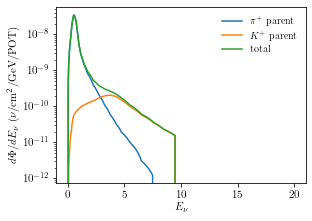

In [17]:
fig = plt.figure()
ax = fig.add_axes(plot_style.axes_form)

x=np.linspace(0,20,1000)

ax.plot(x,fpi(x), label='$\pi^+$ parent')
ax.plot(x,fK(x), label='$K^+$ parent')

ax.plot(x,fpi(x) + fK(x), label='total')

ax.set_xlabel(r"$E_\nu$")
ax.set_ylabel(r"$d\Phi/dE_\nu$ ($\nu$/cm$^2$/GeV/POT)")
ax.set_yscale('log')


ax.legend(loc='upper right', frameon=False)
ax.patch.set_facecolor('None')
fig.savefig("plots/nd280_FHC_nufluxes.png", dpi=400)

# Shrock FunctioN

In [18]:
lp.pi_plus.mass

139.57039

In [19]:
Nflux.get_Rapp(0.140, parent = lp.pi_plus, daughter = lp.e_plus)

array(0.)

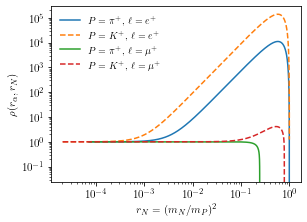

In [20]:
fig = plt.figure()
ax = fig.add_axes(plot_style.axes_form)


mN_K = np.logspace(-5,np.log10(lp.K_plus.mass/1e3),10000, endpoint=False)
mN_pi = np.logspace(-5,np.log10(lp.pi_plus.mass/1e3),10000, endpoint=False)

ax.plot(mN_pi/(lp.pi_plus.mass/1e3), Nflux.get_Rapp(mN_pi, parent = lp.pi_plus, daughter = lp.e_plus), label=r'$P=\pi^+,\,\ell=e^+$')
ax.plot(mN_K/(lp.K_plus.mass/1e3), Nflux.get_Rapp(mN_K, parent = lp.K_plus, daughter = lp.e_plus), label=r'$P=K^+,\,\ell=e^+$',ls='--')

ax.plot(mN_pi/(lp.pi_plus.mass/1e3), Nflux.get_Rapp(mN_pi, parent = lp.pi_plus, daughter = lp.mu_plus), label=r'$P=\pi^+,\,\ell=\mu^+$')
ax.plot(mN_K/(lp.K_plus.mass/1e3), Nflux.get_Rapp(mN_K, parent = lp.K_plus, daughter = lp.mu_plus), label=r'$P=K^+,\,\ell=\mu^+$',ls='--')

ax.set_ylabel(r"$\rho(r_\alpha,r_N)$")
ax.set_xlabel(r"$r_N=(m_N/m_P)^2$")
ax.set_yscale("log")
ax.set_xscale("log")

ax.legend(loc='upper left', frameon=False)
ax.patch.set_facecolor('None')
fig.savefig("plots/rho_function.png", dpi=400)

# Approximation for HNL flux

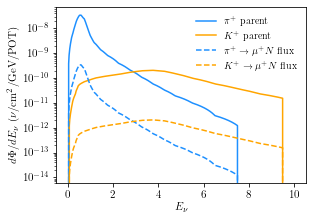

In [21]:
fig = plt.figure()
ax = fig.add_axes(plot_style.axes_form)

x=np.linspace(0,10,1000)
MN = 0.01
USQR = 1e-2


phiN_pi = Nflux.dphi_dEN_app(fpi, x, Ualpha4SQR=USQR, mN=MN, parent=lp.pi_plus, daughter=lp.mu_plus)
phiN_K = Nflux.dphi_dEN_app(fK, x, Ualpha4SQR=USQR, mN=MN, parent=lp.K_plus, daughter=lp.mu_plus)

ax.plot(x,fpi(x), label=r'$\pi^+$ parent', color= 'dodgerblue')
ax.plot(x,fK(x), label=r'$K^+$ parent', color='orange')

ax.plot(x,phiN_pi, label=r'$\pi^+ \to \mu^+ N$ flux', ls='--', color= 'dodgerblue')
ax.plot(x,phiN_K, label=r'$K^+  \to \mu^+ N$ flux', ls='--', color='orange')

ax.set_xlabel(r"$E_\nu$")
ax.set_ylabel(r"$d\Phi/dE_\nu$ ($\nu$/cm$^2$/GeV/POT)")
ax.set_yscale('log')

ax.legend(loc='upper right', frameon=False)
ax.patch.set_facecolor('None')
fig.savefig("plots/HNL_fluxes_mN_150.png", dpi=400)

# Probability of decay

In [39]:
UMU4 = np.sqrt(1e-4)
my_hnl = model.hnl_model(m4=0.150, mixings=[0.0,UMU4, 0.0])

my_hnl.set_high_level_variables()

[autoreload of HNL_MC.const failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.framework/Versions/3.9/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.framework/Versions/3.9/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 855, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/matheushostert/Repos/stdHNL/HNL_MC/const.py", line 90, in <module>
    c12 = cmat

# Compute number of decays in TPCs

In [38]:
my_hnl_decays = rates.N_decay(my_hnl)
my_hnl_decays.compute_rates()

NameError: name 'Vud' is not defined